In [1]:
import networkx as nx
import pandas as pd
import numpy as np

import utils
import os
import json
import matplotlib
import matplotlib.pyplot as plt
import pickle
import seaborn as sns

from sklearn.metrics import ndcg_score
from scipy import stats
from tqdm import tqdm

plt.rcParams["figure.figsize"] = (16,9)
font = {'size'   : 22}
matplotlib.rc('font', **font)

In [2]:
def get_sampling_ranks_dir(df, dir, name):
    for subdir in os.listdir(dir):
        with open(dir+subdir+'/args.json') as json_file:
            args = json.load(json_file)
        
        df_tmp = pickle.load(open(dir+subdir+'/compression_metadata/'+'df_compressed.pickle', 'rb'))
        df_tmp = df_tmp[df_tmp['node_type'] == 'cell']

        sampling_percentage = str(int(args['sampling_percentage']))
        col_name = sampling_percentage + '_' + name + '_dense_rank' 

        df_tmp[col_name] = df_tmp['approximate_betweenness_centrality'].rank(method='dense', ascending=False)

        if df.empty:
            df['node'] = df_tmp['node']
            df['node_type'] = df_tmp['node_type']
            df[col_name] = df_tmp[col_name]
        else: 
            df[col_name] = df_tmp[col_name]

    return df

def get_runtime_dict(dir, sampling_mode, time_dict):
    for subdir in os.listdir(dir):
        with open(dir+subdir+'/args.json') as json_file:
            args = json.load(json_file)
        with open(dir+subdir+'/statistics.json') as json_file:
            stats = json.load(json_file)

        time = stats['bc_time']
        sample_percentage = int(args['sampling_percentage'])

        time_dict['sample_percentage'].append(sample_percentage)
        time_dict['time'].append(time)
        time_dict['sampling_mode'].append(sampling_mode)
    return


def update_scores_dict(df, base_col, scores_dict, sampling_mode):
    df.sort_values(by=base_col, inplace=True)
    for sample_percentage in tqdm(range(5, 101, 5)):
        base_rank = df[base_col].tolist()
        sampling_ranks = df[str(sample_percentage)+'_'+sampling_mode+'_dense_rank'].tolist()

        tau, p_val = stats.kendalltau(base_rank, sampling_ranks)
        spearmanr, p_val = stats.spearmanr(base_rank, sampling_ranks)

        rbo_score = utils.rbo(base_rank, sampling_ranks, p=0.95).ext

        scores_dict['sample_percentage'].append(sample_percentage)
        scores_dict['tau'].append(tau)
        scores_dict['spearmanr'].append(spearmanr)
        scores_dict['rbo'].append(rbo_score)
        scores_dict['sampling_mode'].append(sampling_mode)

    return


# Synthetic Benchmark

In [3]:
df_unweighted_dir = 'output/node_compression/SB/unweighted_sampling/'
df_weighted_dir = 'output/node_compression/SB/weighted_sampling/'

df = pd.DataFrame()
get_sampling_ranks_dir(df, df_unweighted_dir, 'unweighted')
get_sampling_ranks_dir(df, df_weighted_dir, 'weighted')

df

,node,node_type,50_unweighted_dense_rank,40_unweighted_dense_rank,75_unweighted_dense_rank,5_unweighted_dense_rank,70_unweighted_dense_rank,45_unweighted_dense_rank,80_unweighted_dense_rank,20_unweighted_dense_rank,...,30_weighted_dense_rank,65_weighted_dense_rank,25_weighted_dense_rank,90_weighted_dense_rank,60_weighted_dense_rank,95_weighted_dense_rank,55_weighted_dense_rank,35_weighted_dense_rank,100_weighted_dense_rank,10_weighted_dense_rank
2,Mali,cell,61.0,64.0,58.0,55.0,58.0,62.0,58.0,61.0,...,62.0,60.0,71.0,58.0,60.0,58.0,61.0,64.0,58.0,29.0
3,Haiti,cell,62.0,61.0,65.0,50.0,65.0,61.0,65.0,56.0,...,68.0,69.0,70.0,66.0,69.0,66.0,69.0,69.0,66.0,29.0
4,Ecuador,cell,37.0,38.0,36.0,27.0,36.0,35.0,36.0,36.0,...,37.0,39.0,37.0,37.0,39.0,37.0,39.0,37.0,37.0,29.0
5,Burkina Faso,cell,65.0,71.0,66.0,58.0,66.0,67.0,66.0,62.0,...,60.0,59.0,54.0,67.0,59.0,67.0,59.0,61.0,67.0,29.0
6,Denmark,cell,54.0,59.0,54.0,45.0,54.0,56.0,54.0,41.0,...,51.0,48.0,51.0,55.0,48.0,55.0,47.0,53.0,55.0,29.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,compressed_node_77,cell,101.0,101.0,101.0,86.0,101.0,101.0,101.0,96.0,...,101.0,101.0,100.0,101.0,101.0,101.0,101.0,101.0,101.0,29.0
174,compressed_node_78,cell,101.0,101.0,101.0,86.0,101.0,101.0,101.0,96.0,...,101.0,101.0,100.0,101.0,101.0,101.0,101.0,101.0,101.0,29.0
175,compressed_node_79,cell,101.0,101.0,101.0,86.0,101.0,101.0,101.0,96.0,...,101.0,101.0,100.0,101.0,101.0,101.0,101.0,101.0,101.0,29.0
176,compressed_node_80,cell,101.0,101.0,101.0,86.0,101.0,101.0,101.0,96.0,...,101.0,101.0,100.0,101.0,101.0,101.0,101.0,101.0,101.0,29.0


In [4]:
scores_dict = {'sample_percentage': [], 'tau': [], 'spearmanr': [], 'sampling_mode': [], 'rbo': []}

update_scores_dict(df=df, base_col='100_unweighted_dense_rank', scores_dict=scores_dict, sampling_mode='unweighted')
update_scores_dict(df=df, base_col='100_weighted_dense_rank', scores_dict=scores_dict, sampling_mode='weighted')

df_scores = pd.DataFrame.from_dict(scores_dict)
df_scores.head()

100%|██████████| 20/20 [00:00<00:00, 231.49it/s]


,sample_percentage,tau,spearmanr,sampling_mode,rbo
0,5,0.729583,0.776589,unweighted,0.609479
1,10,0.735084,0.801793,unweighted,0.616781
2,15,0.742058,0.820101,unweighted,0.617652
3,20,0.799941,0.891090,unweighted,0.620035
4,25,0.803828,0.884431,unweighted,0.717133


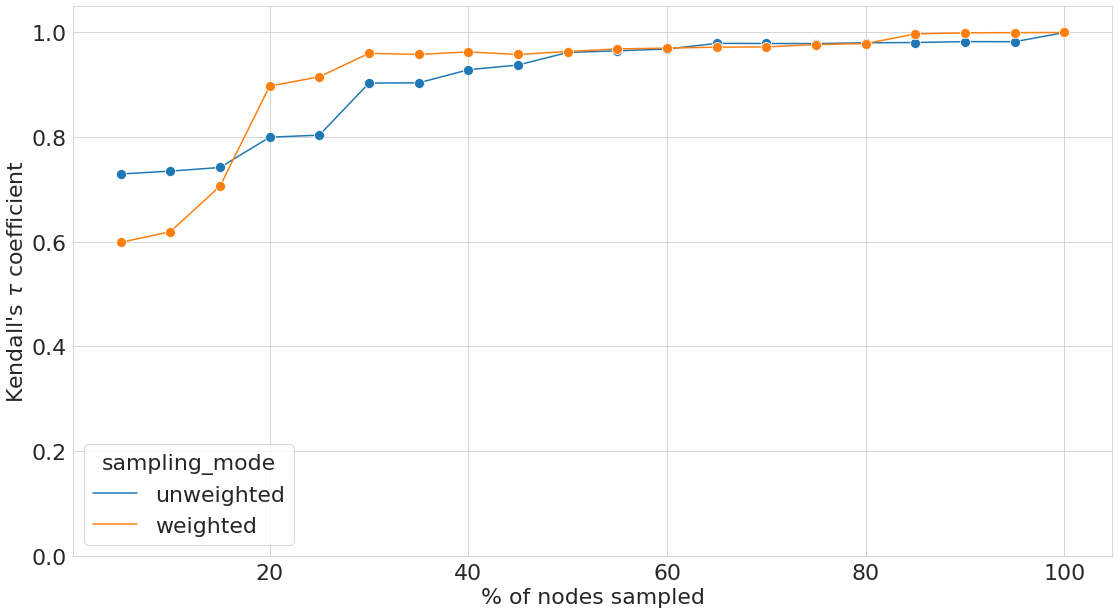

In [5]:
ax =sns.lineplot(data=df_scores, x='sample_percentage', y='tau', hue='sampling_mode', markers=True, marker="o", markersize=10)
ax.set(xlabel='% of nodes sampled', ylabel=r"Kendall's $\tau$ coefficient", ylim=(0, 1.05))
plt.tight_layout()
plt.savefig('figures/graph_compression_experiments/SB_kendall_tau.svg')

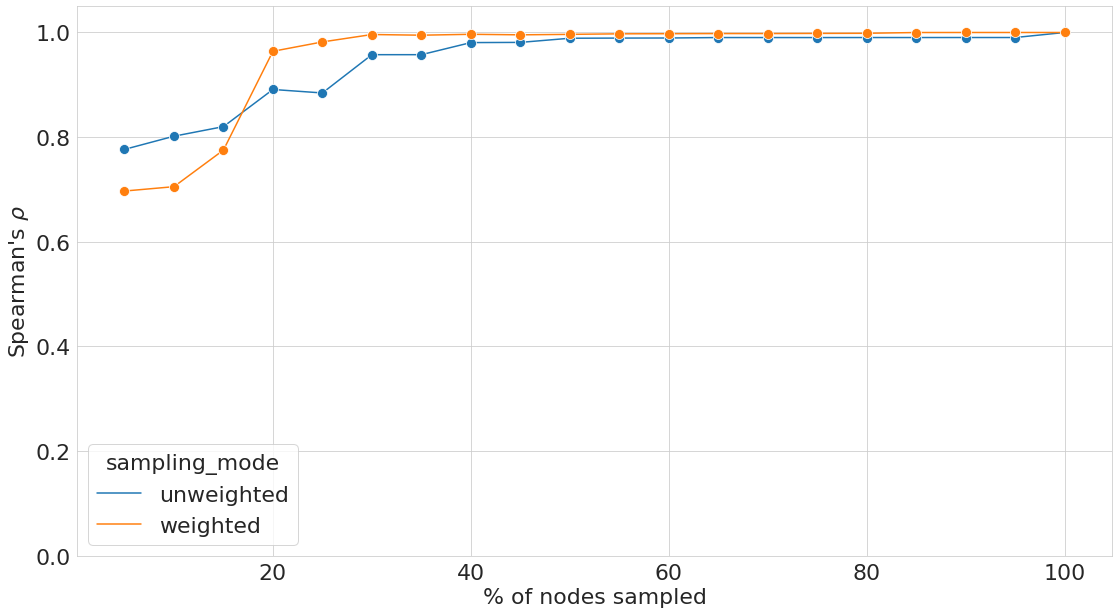

In [6]:
ax =sns.lineplot(data=df_scores, x='sample_percentage', y='spearmanr', hue='sampling_mode', markers=True, marker="o", markersize=10)
ax.set(xlabel='% of nodes sampled', ylabel=r"Spearman's $\rho$", ylim=(0, 1.05))
plt.tight_layout()

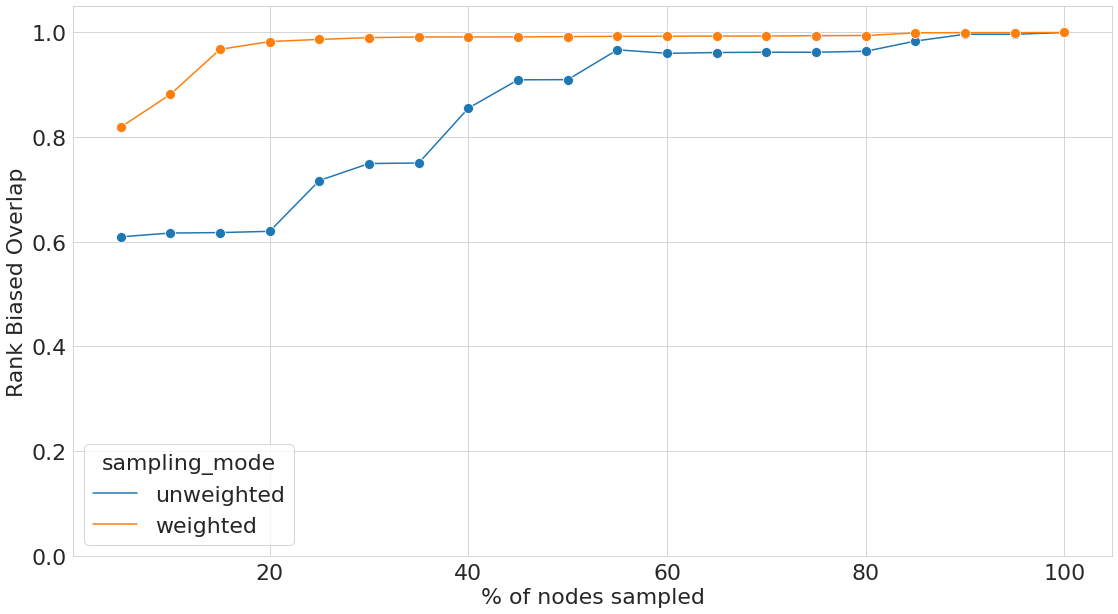

In [7]:
ax =sns.lineplot(data=df_scores, x='sample_percentage', y='rbo', hue='sampling_mode', markers=True, marker="o", markersize=10)
ax.set(xlabel='% of nodes sampled', ylabel="Rank Biased Overlap", ylim=(0, 1.05))
plt.tight_layout()
plt.savefig('figures/graph_compression_experiments/SB_rbo.svg')

In [8]:
time_dict = {'sample_percentage': [], 'time': [], 'sampling_mode': []}
get_runtime_dict(df_unweighted_dir, 'unweighted', time_dict)
get_runtime_dict(df_weighted_dir, 'weighted', time_dict)
df_time = pd.DataFrame.from_dict(time_dict)
df_time.sort_values(by=['sampling_mode', 'sample_percentage'], inplace=True)
df_time.head()

,sample_percentage,time,sampling_mode
3,5,0.269440,unweighted
19,10,0.248852,unweighted
9,15,0.188738,unweighted
7,20,0.251279,unweighted
12,25,0.232477,unweighted


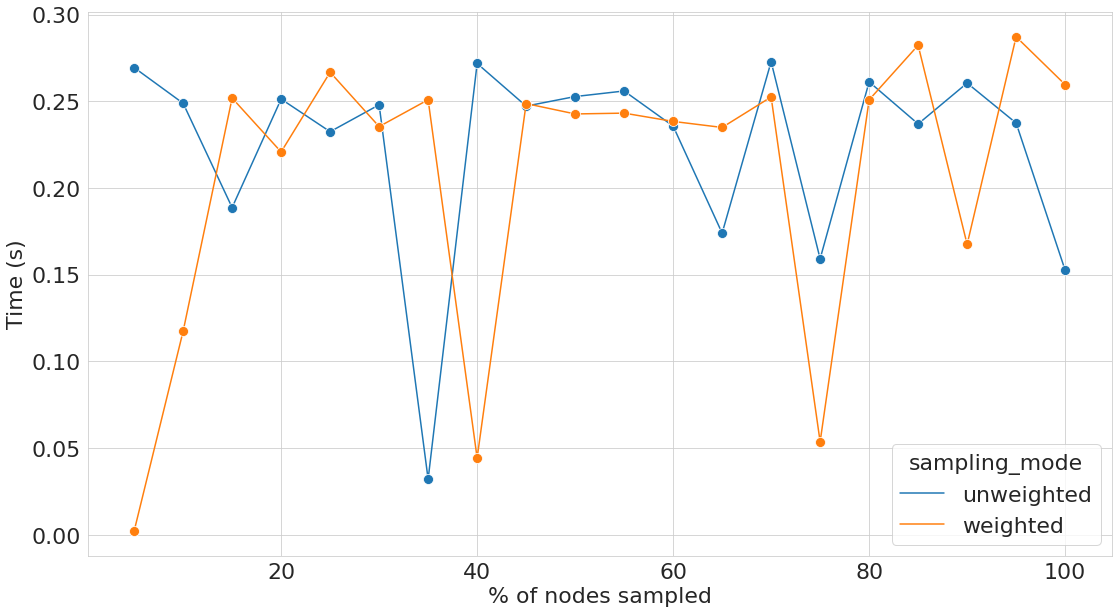

In [9]:
ax =sns.lineplot(data=df_time, x='sample_percentage', y='time', hue='sampling_mode', markers=True, marker="o", markersize=10)
ax.set(xlabel='% of nodes sampled', ylabel="Time (s)")
plt.tight_layout()

# TUS Benchmark

In [10]:
df_unweighted_dir = 'output/node_compression/TUS/unweighted_sampling/'
df_weighted_dir = 'output/node_compression/TUS/weighted_sampling/'

df = pd.DataFrame()
get_sampling_ranks_dir(df, df_unweighted_dir, 'unweighted')
get_sampling_ranks_dir(df, df_weighted_dir, 'weighted')

df

,node,node_type,50_unweighted_dense_rank,40_unweighted_dense_rank,75_unweighted_dense_rank,5_unweighted_dense_rank,70_unweighted_dense_rank,45_unweighted_dense_rank,80_unweighted_dense_rank,20_unweighted_dense_rank,...,30_weighted_dense_rank,65_weighted_dense_rank,25_weighted_dense_rank,90_weighted_dense_rank,60_weighted_dense_rank,95_weighted_dense_rank,55_weighted_dense_rank,35_weighted_dense_rank,100_weighted_dense_rank,10_weighted_dense_rank
7,OGM Asia Pacific,cell,2413.0,2416.0,2411.0,2348.0,2412.0,2417.0,2411.0,2406.0,...,2453.0,2436.0,2482.0,2415.0,2445.0,2408.0,2444.0,2446.0,2407.0,2558.0
8,OAD Asia Programming,cell,742.0,714.0,759.0,714.0,756.0,721.0,769.0,689.0,...,799.0,796.0,798.0,787.0,795.0,787.0,791.0,799.0,782.0,802.0
9,Canadian Profit Making,cell,2378.0,2379.0,2376.0,2377.0,2378.0,2380.0,2375.0,2386.0,...,2412.0,2385.0,2430.0,2378.0,2386.0,2373.0,2392.0,2403.0,2372.0,2458.0
10,Not PBA,cell,2268.0,2266.0,2293.0,2142.0,2295.0,2276.0,2289.0,2286.0,...,2368.0,2308.0,2376.0,2298.0,2315.0,2292.0,2324.0,2349.0,2286.0,2414.0
11,"EGM Europe, Middle East and Maghreb",cell,2456.0,2460.0,2452.0,2393.0,2451.0,2462.0,2457.0,2440.0,...,2506.0,2480.0,2535.0,2462.0,2496.0,2459.0,2494.0,2497.0,2455.0,2574.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12874,compressed_node_1503,cell,1348.0,1275.0,1276.0,1145.0,1253.0,1315.0,1289.0,1266.0,...,1255.0,1264.0,1254.0,1271.0,1264.0,1271.0,1264.0,1256.0,1271.0,1251.0
12875,compressed_node_1504,cell,1731.0,1655.0,1703.0,1953.0,1691.0,1694.0,1720.0,1619.0,...,1715.0,1724.0,1715.0,1727.0,1723.0,1726.0,1720.0,1720.0,1727.0,1707.0
12876,compressed_node_1505,cell,3004.0,2999.0,3003.0,2895.0,3007.0,3000.0,3003.0,2996.0,...,2998.0,3001.0,2988.0,2999.0,3003.0,3000.0,3004.0,2987.0,2985.0,2910.0
12877,compressed_node_1506,cell,1665.0,1670.0,1640.0,1294.0,1654.0,1671.0,1649.0,1640.0,...,1522.0,1532.0,1520.0,1539.0,1531.0,1540.0,1528.0,1525.0,1542.0,1517.0


In [11]:
scores_dict = {'sample_percentage': [], 'tau': [], 'spearmanr': [], 'sampling_mode': [], 'rbo': []}

update_scores_dict(df=df, base_col='100_unweighted_dense_rank', scores_dict=scores_dict, sampling_mode='unweighted')
update_scores_dict(df=df, base_col='100_weighted_dense_rank', scores_dict=scores_dict, sampling_mode='weighted')

df_scores = pd.DataFrame.from_dict(scores_dict)
df_scores.head()

100%|██████████| 20/20 [00:29<00:00,  1.46s/it]


,sample_percentage,tau,spearmanr,sampling_mode,rbo
0,5,0.837528,0.957686,unweighted,0.723570
1,10,0.873649,0.972163,unweighted,0.799083
2,15,0.882865,0.975499,unweighted,0.758680
3,20,0.897039,0.980565,unweighted,0.769469
4,25,0.908591,0.985317,unweighted,0.820899


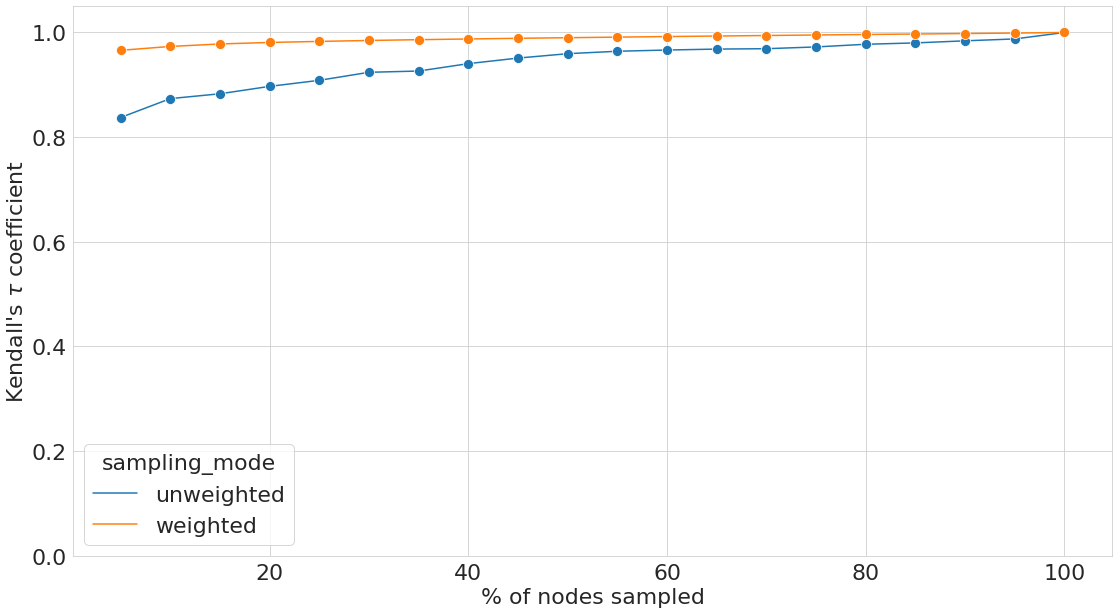

In [13]:
ax =sns.lineplot(data=df_scores, x='sample_percentage', y='tau', hue='sampling_mode', markers=True, marker="o", markersize=10)
ax.set(xlabel='% of nodes sampled', ylabel=r"Kendall's $\tau$ coefficient", ylim=(0, 1.05))
plt.tight_layout()
plt.savefig('figures/graph_compression_experiments/TUS_kendall_tau.svg')

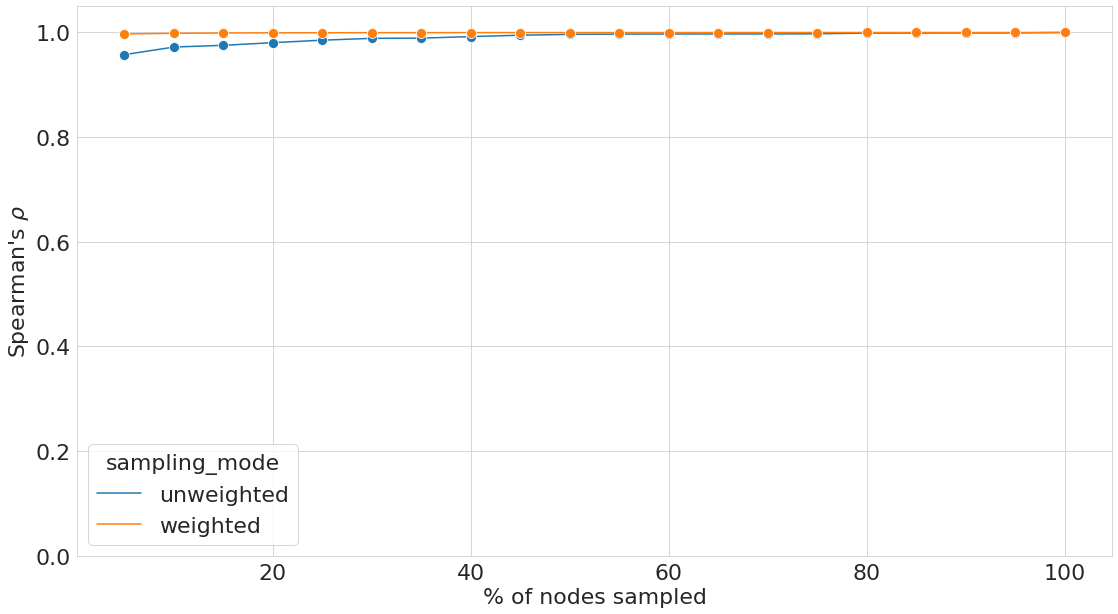

In [14]:
ax =sns.lineplot(data=df_scores, x='sample_percentage', y='spearmanr', hue='sampling_mode', markers=True, marker="o", markersize=10)
ax.set(xlabel='% of nodes sampled', ylabel=r"Spearman's $\rho$", ylim=(0, 1.05))
plt.tight_layout()

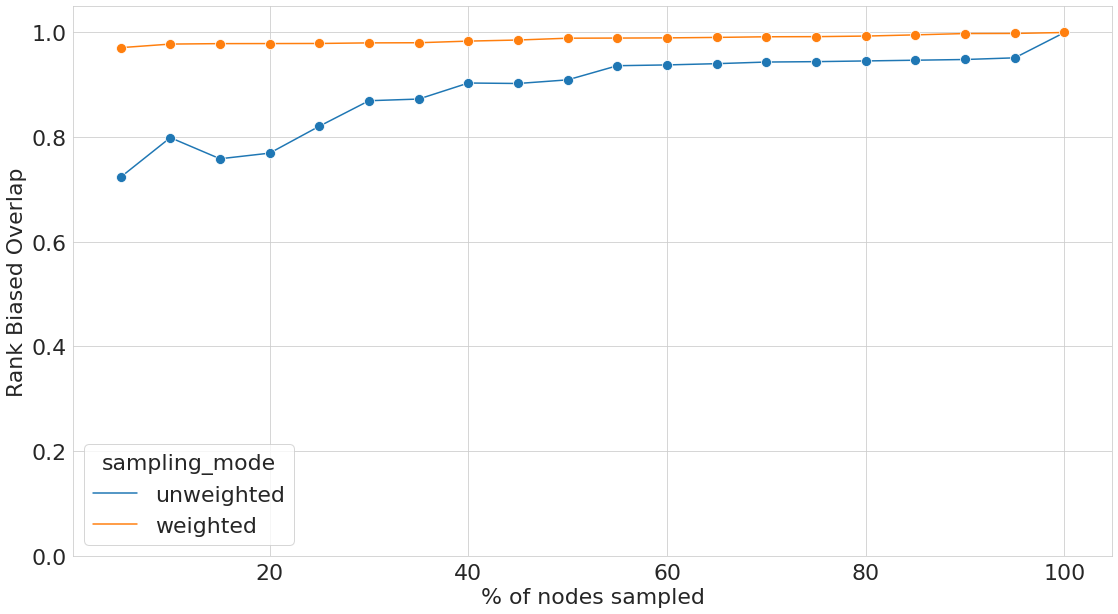

In [15]:
ax =sns.lineplot(data=df_scores, x='sample_percentage', y='rbo', hue='sampling_mode', markers=True, marker="o", markersize=10)
ax.set(xlabel='% of nodes sampled', ylabel="Rank Biased Overlap", ylim=(0, 1.05))
plt.tight_layout()
plt.savefig('figures/graph_compression_experiments/TUS_rbo.svg')

In [16]:
time_dict = {'sample_percentage': [], 'time': [], 'sampling_mode': []}
get_runtime_dict(df_unweighted_dir, 'unweighted', time_dict)
get_runtime_dict(df_weighted_dir, 'weighted', time_dict)
df_time = pd.DataFrame.from_dict(time_dict)
df_time.sort_values(by=['sampling_mode', 'sample_percentage'], inplace=True)
df_time.head()

,sample_percentage,time,sampling_mode
3,5,1.189006,unweighted
19,10,2.290299,unweighted
9,15,3.335948,unweighted
7,20,4.393773,unweighted
12,25,5.529455,unweighted


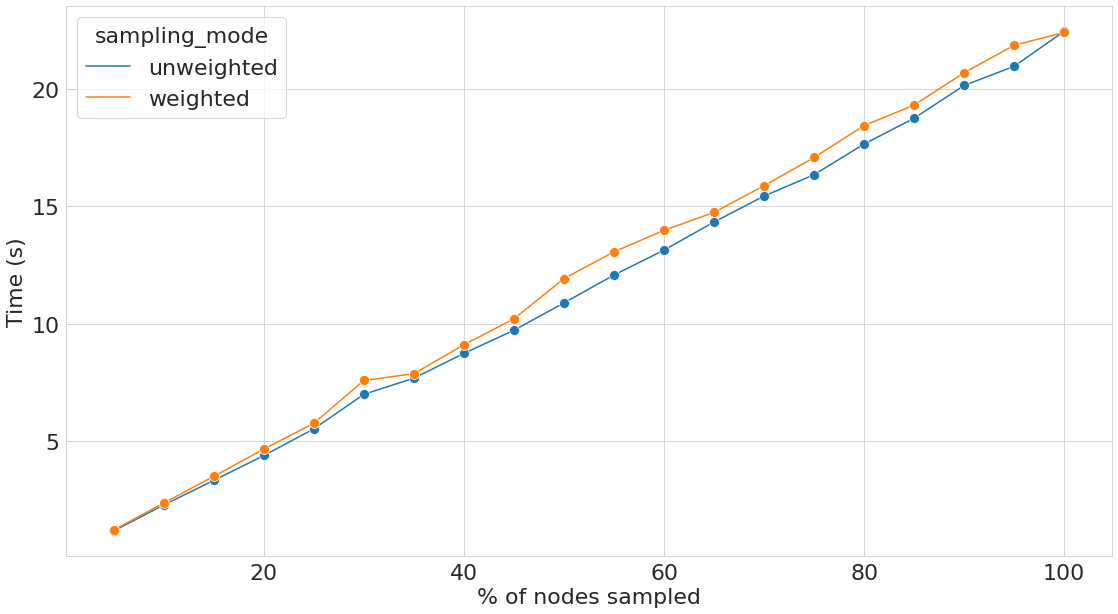

In [17]:
ax =sns.lineplot(data=df_time, x='sample_percentage', y='time', hue='sampling_mode', markers=True, marker="o", markersize=10)
ax.set(xlabel='% of nodes sampled', ylabel="Time (s)")
plt.tight_layout()
plt.savefig('figures/graph_compression_experiments/TUS_weighted_vs_unweighted_time.svg')

# Scaling Experiments on D4 Education dataset

In [19]:
dir = 'output/node_compression/scaling/education/'

scale_dict = {'sample_percentage': [], 'num_nodes': [], 'num_edges': [], 'compressed_graph_num_nodes': [], 'compressed_graph_num_edges': [], 'num_compressed_nodes': []}

for subdir in os.listdir(dir):
    with open(dir+subdir+'/args.json') as json_file:
        args = json.load(json_file)

    with open(dir+subdir+'/statistics.json') as json_file:
        stats = json.load(json_file)

    sample_percentage = int(args['sampling_percentage'])

    scale_dict['sample_percentage'].append(sample_percentage)
    scale_dict['num_nodes'].append(stats['num_nodes'])
    scale_dict['num_edges'].append(stats['num_edges'])
    scale_dict['compressed_graph_num_nodes'].append(stats['compressed_graph_num_nodes'])
    scale_dict['compressed_graph_num_edges'].append(stats['compressed_graph_num_edges'])
    scale_dict['num_compressed_nodes'].append(stats['num_compressed_nodes'])

df_scale = pd.DataFrame.from_dict(scale_dict)
df_scale['node_reduction_factor'] = df_scale['num_nodes'] / df_scale['compressed_graph_num_nodes'] 
df_scale['edge_reduction_factor'] = df_scale['num_edges'] / df_scale['compressed_graph_num_edges'] 
df_scale.sort_values(by='sample_percentage', inplace=True)
df_scale

,sample_percentage,num_nodes,num_edges,compressed_graph_num_nodes,compressed_graph_num_edges,num_compressed_nodes,node_reduction_factor,edge_reduction_factor
1,5,73467,5761,402,1143,92,182.753731,5.040245
8,10,146934,22262,1125,5485,227,130.608000,4.058706
17,15,220401,54959,1748,12735,278,126.087529,4.315587
0,20,293868,79831,2506,20873,442,117.265762,3.824606
19,25,367335,117701,3571,35186,607,102.866144,3.345109
14,30,440802,197025,4571,53784,769,96.434478,3.663264
10,35,514269,139701,5163,66569,918,99.606624,2.098589
7,40,587736,259402,7307,97431,1303,80.434652,2.662418
12,45,661203,361614,7759,113195,1389,85.217554,3.194611
9,50,734670,390178,9419,151592,1669,77.998726,2.573869


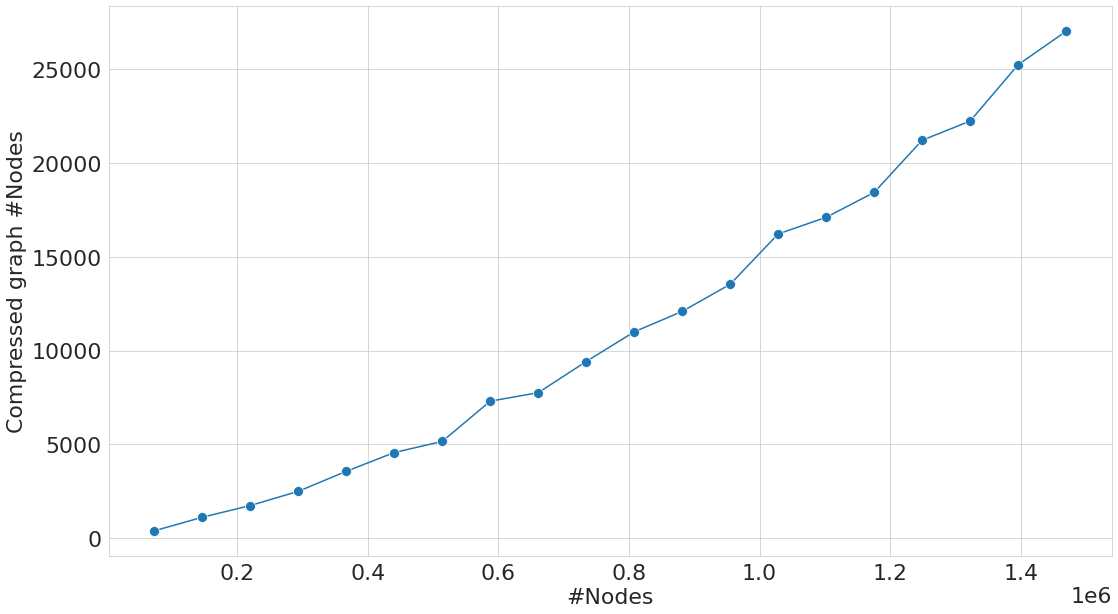

In [22]:
ax =sns.lineplot(data=df_scale, x='num_nodes', y='compressed_graph_num_nodes', markers=True, marker="o", markersize=10)
ax.set(xlabel='#Nodes', ylabel="Compressed graph #Nodes")
plt.tight_layout()
plt.savefig('figures/graph_compression_experiments/D4_education_num_compressed_nodes_scalability.svg')

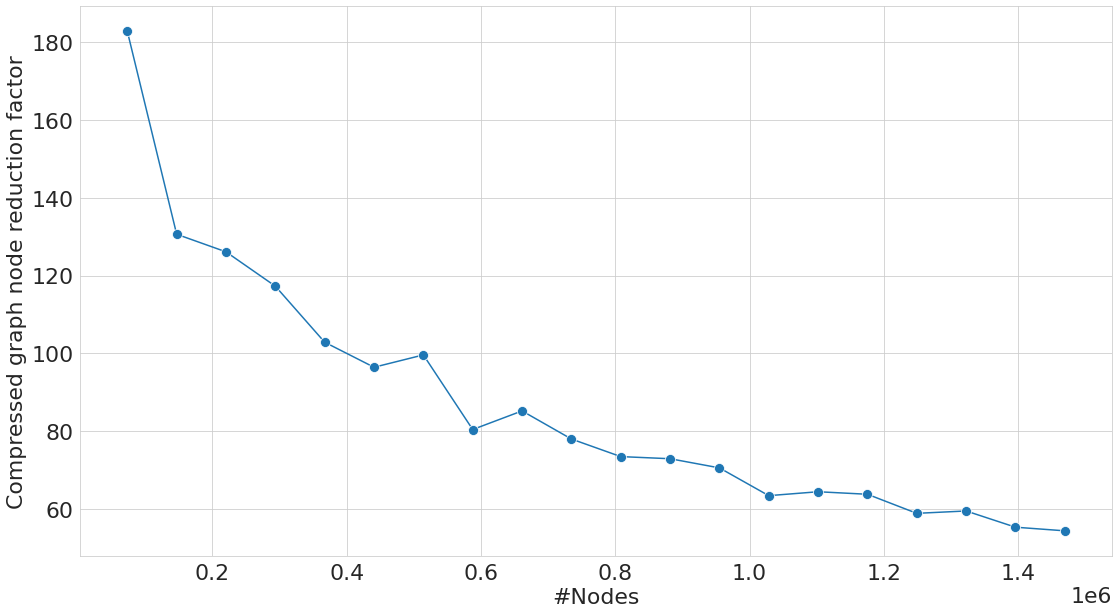

In [23]:
ax =sns.lineplot(data=df_scale, x='num_nodes', y='node_reduction_factor', markers=True, marker="o", markersize=10)
ax.set(xlabel='#Nodes', ylabel="Compressed graph node reduction factor")
plt.tight_layout()
plt.savefig('figures/graph_compression_experiments/D4_education_num_reduction_factor_scalability.svg')

In [25]:
reduction_factor_dict = {'dataset': [], 'node_reduction_factor': [], 'edge_reduction_factor': [], 'complexity_reduction_factor': [], 'num_nodes': [], 'num_edges': []}

def get_reduction_factor(stats_path, reduction_factor_dict, dataset_name):
    with open(stats_path) as json_file:
        stats = json.load(json_file)
        reduction_factor_dict['dataset'].append(dataset_name)
        reduction_factor_dict['node_reduction_factor'].append(stats['num_nodes'] / stats['compressed_graph_num_nodes'])
        reduction_factor_dict['edge_reduction_factor'].append(stats['num_edges'] / stats['compressed_graph_num_edges'])
        reduction_factor_dict['complexity_reduction_factor'].append((stats['num_nodes'] * stats['num_edges']) / (stats['compressed_graph_num_nodes'] * stats['compressed_graph_num_edges']))
        reduction_factor_dict['num_nodes'].append(stats['num_nodes'])
        reduction_factor_dict['num_edges'].append(stats['num_edges'])

get_reduction_factor('output/node_compression/SB/unweighted_sampling/sampling_100_percent/statistics.json', reduction_factor_dict, 'SB')
get_reduction_factor('output/node_compression/TUS/unweighted_sampling/sampling_100_percent/statistics.json', reduction_factor_dict, 'TUS')
get_reduction_factor('output/node_compression/D4/education/statistics.json', reduction_factor_dict, 'D4-education')
get_reduction_factor('output/node_compression/D4/finance/statistics.json', reduction_factor_dict, 'D4-finance')

df_reduction_factor = pd.DataFrame.from_dict(reduction_factor_dict)
df_reduction_factor


,dataset,node_reduction_factor,edge_reduction_factor,complexity_reduction_factor,num_nodes,num_edges
0,SB,99.280899,51.928000,5155.458517,17672,19473
1,TUS,15.549189,19.102458,297.027724,200258,4150563
2,D4-education,54.407872,3.877278,210.954450,1469339,2339821
3,D4-finance,144.120782,18.210264,2624.477537,18854169,25146645


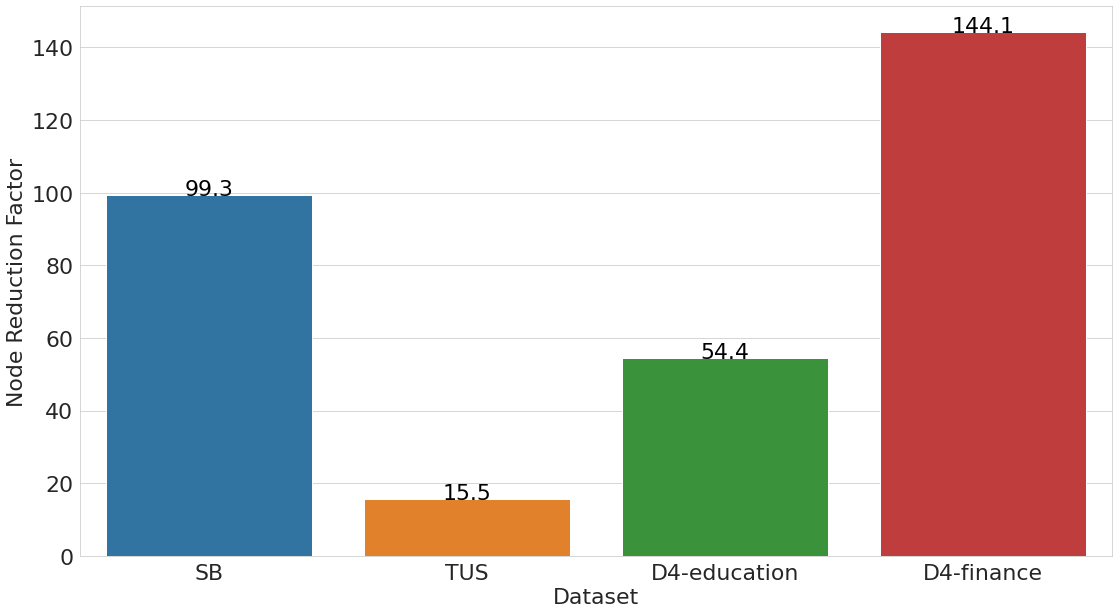

In [26]:
ax = sns.barplot(data=df_reduction_factor, x='dataset', y='node_reduction_factor')
ax.set(xlabel='Dataset', ylabel="Node Reduction Factor")
for index, row in df_reduction_factor.iterrows():
    ax.text(row.name,row.node_reduction_factor, round(row.node_reduction_factor,1), color='black', ha="center")

plt.tight_layout()
plt.savefig('figures/graph_compression_experiments/node_reduction_factor.svg')

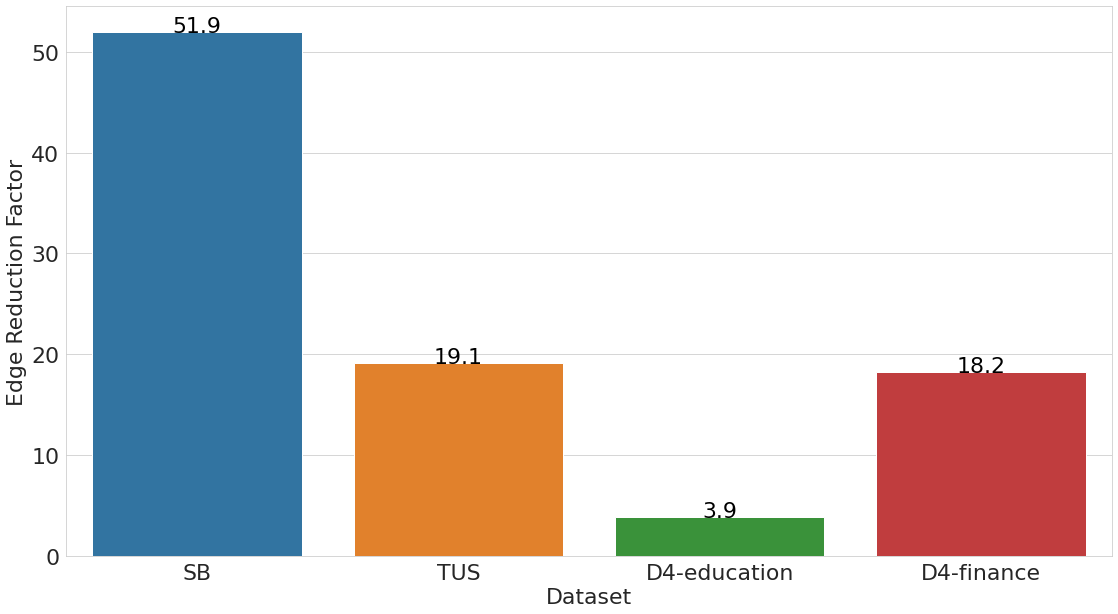

In [27]:
ax = sns.barplot(data=df_reduction_factor, x='dataset', y='edge_reduction_factor')
ax.set(xlabel='Dataset', ylabel="Edge Reduction Factor")
for index, row in df_reduction_factor.iterrows():
    ax.text(row.name,row.edge_reduction_factor, round(row.edge_reduction_factor,1), color='black', ha="center")

plt.tight_layout()
plt.savefig('figures/graph_compression_experiments/edge_reduction_factor.svg')

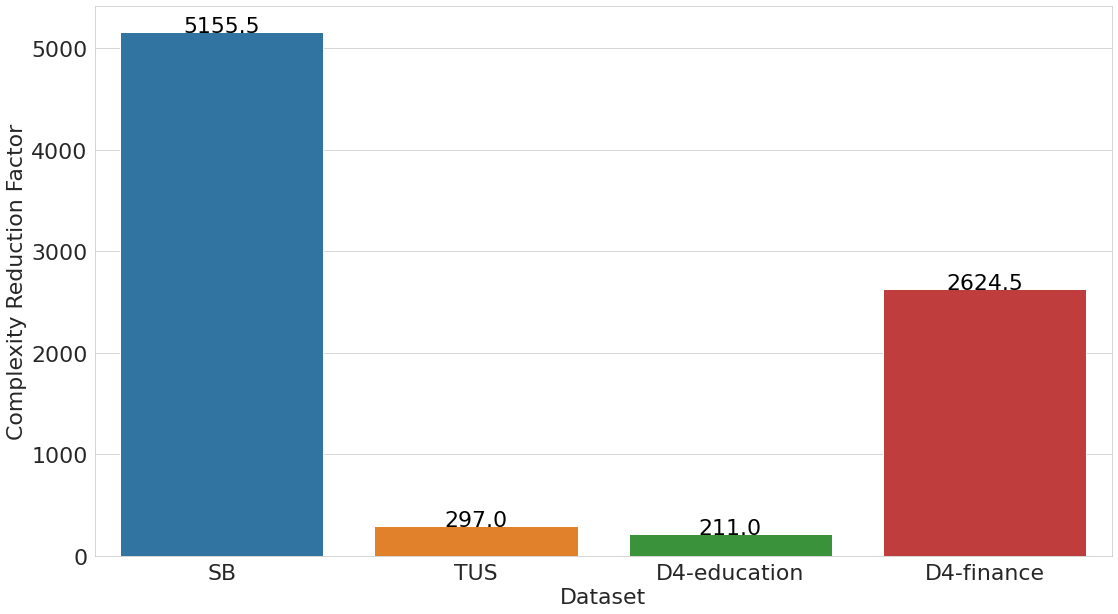

In [28]:
ax = sns.barplot(data=df_reduction_factor, x='dataset', y='complexity_reduction_factor')
ax.set(xlabel='Dataset', ylabel="Complexity Reduction Factor")
for index, row in df_reduction_factor.iterrows():
    ax.text(row.name,row.complexity_reduction_factor, round(row.complexity_reduction_factor,1), color='black', ha="center")

plt.tight_layout()
plt.savefig('figures/graph_compression_experiments/complexity_reduction_factor.svg')